<a href="https://colab.research.google.com/github/dots13/ForecastingStickerSalesKaggle/blob/main/LGBM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

In [ ]:
import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import holidays

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from scipy.fftpack import fft

import sklearn
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder
import optuna


In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [ ]:
train.shape

(230130, 6)

In [ ]:
train[train.isna().any(axis=1)]

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
45,45,2010-01-01,Kenya,Discount Stickers,Holographic Goose,NaN
90,90,2010-01-02,Canada,Discount Stickers,Holographic Goose,NaN
135,135,2010-01-02,Kenya,Discount Stickers,Holographic Goose,NaN
180,180,2010-01-03,Canada,Discount Stickers,Holographic Goose,NaN
...,...,...,...,...,...,...
229905,229905,2016-12-29,Kenya,Discount Stickers,Holographic Goose,NaN
229950,229950,2016-12-30,Canada,Discount Stickers,Holographic Goose,NaN
229995,229995,2016-12-30,Kenya,Discount Stickers,Holographic Goose,NaN
230040,230040,2016-12-31,Canada,Discount Stickers,Holographic Goose,NaN


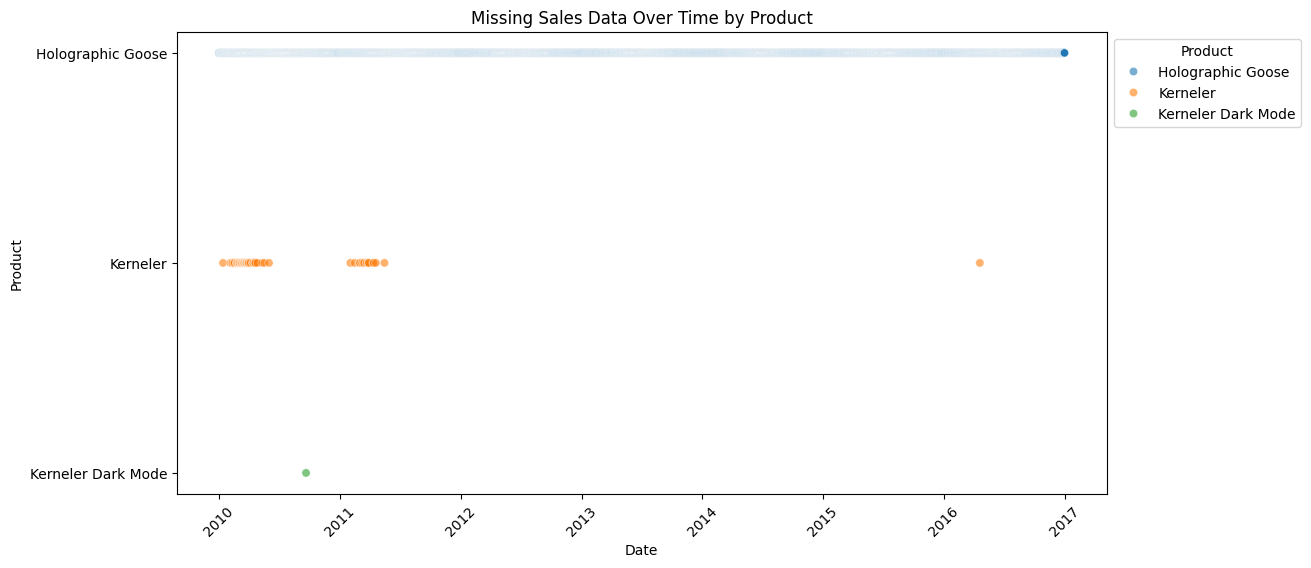

In [ ]:
# Filter rows with NaN values
nan_df = train[train.isna().any(axis=1)]
nan_df.loc[:, "date"] = pd.to_datetime(nan_df["date"])
plt.figure(figsize=(12, 6))
sns.scatterplot(data=nan_df, x="date", y="product", hue="product", alpha=0.6)
plt.title("Missing Sales Data Over Time by Product")
plt.xlabel("Date")
plt.ylabel("Product")
plt.xticks(rotation=45)
plt.legend(title="Product", bbox_to_anchor=(1, 1))
plt.show()

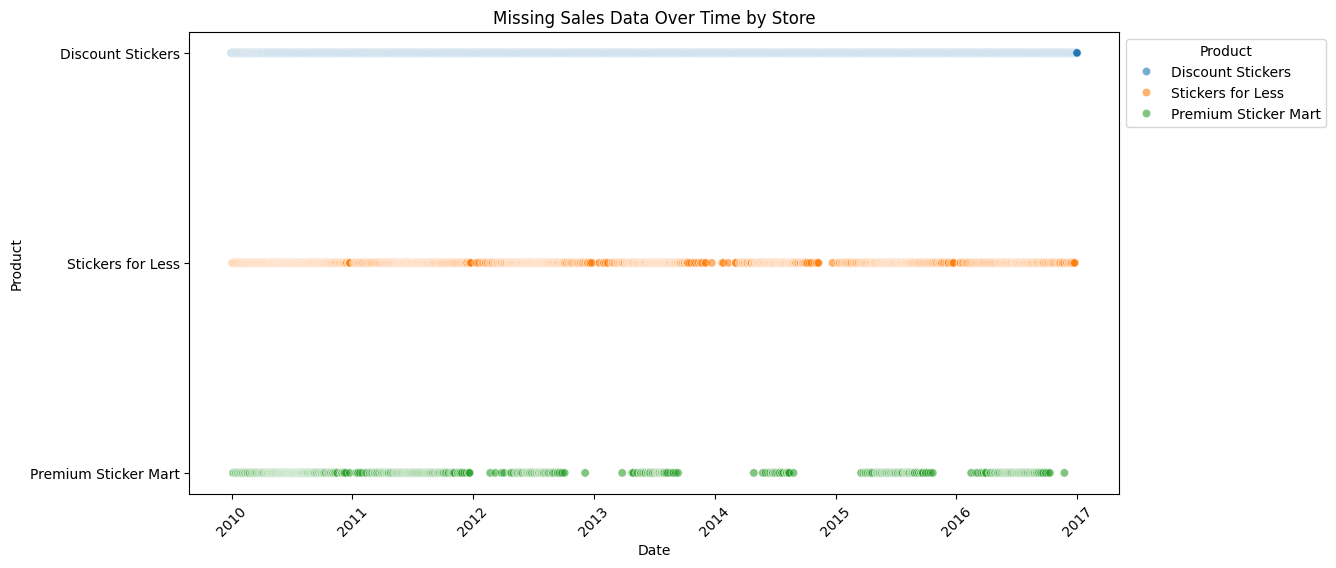

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=nan_df, x="date", y="store", hue="store", alpha=0.6)
plt.title("Missing Sales Data Over Time by Store")
plt.xlabel("Date")
plt.ylabel("Product")
plt.xticks(rotation=45)
plt.legend(title="Product", bbox_to_anchor=(1, 1))
plt.show()

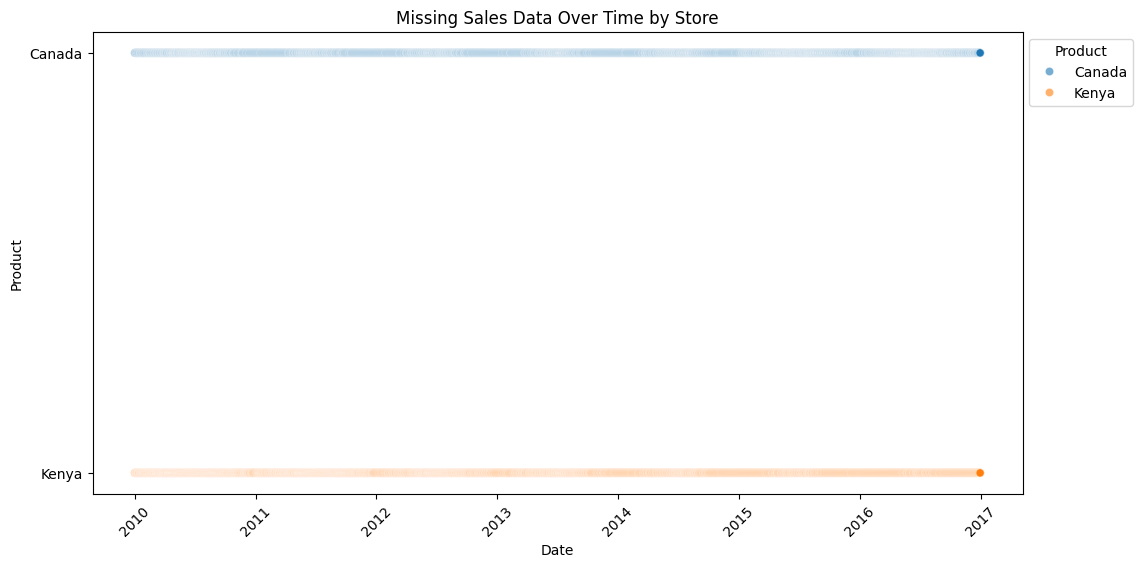

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=nan_df, x="date", y="country", hue="country", alpha=0.6)
plt.title("Missing Sales Data Over Time by Store")
plt.xlabel("Date")
plt.ylabel("Product")
plt.xticks(rotation=45)
plt.legend(title="Product", bbox_to_anchor=(1, 1))
plt.show()

## https://www.kaggle.com/code/sulaniishara/sticker-sales-analysis-forecasting

In [ ]:
# Function to fetch GDP per capita for a given country and year
def get_gdp_per_capita(alpha3, year):
    """
    Fetch GDP per capita for a specific country and year from the World Bank API.

    """
    url = f'https://api.worldbank.org/v2/country/{alpha3}/indicator/NY.GDP.PCAP.CD?date={year}&format=json'
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        return data[1][0]['value'] if data[1] else None
    except (requests.RequestException, KeyError, IndexError) as e:
        print(f"Error fetching data for {alpha3} in {year}: {e}")
        return None

In [ ]:
def create_gdp_dataframe(alpha3s, years, country_names):
    """
    Create a DataFrame of normalized GDP per capita ratios for multiple countries and years.

    """
    # Fetch GDP data for all countries and years
    gdp_data = [
        [get_gdp_per_capita(alpha3, year) for year in years]
        for alpha3 in alpha3s
    ]

    # Create a DataFrame with countries as rows and years as columns
    gdp_df = pd.DataFrame(gdp_data, index=country_names, columns=years)

    # Normalize GDP values by dividing by the column sum (yearly total)
    gdp_df = gdp_df / gdp_df.sum(axis=0)

    # Reshape the DataFrame into long format
    gdp_df = gdp_df.reset_index().rename(columns={'index': 'country'})
    gdp_df = gdp_df.melt(id_vars=['country'], var_name='year', value_name='ratio')

    return gdp_df

In [ ]:
def adjust_ratios(gdp_df, adjustments):
    """
    Adjust GDP ratios for specific countries based on custom rules.

    Parameters:
    - gdp_df: DataFrame containing GDP ratios.
    - adjustments: Dictionary with country names as keys and adjustment values.

    Returns:
    - Adjusted DataFrame with updated ratios.
    """
    adjusted_df = gdp_df.copy()

    # Apply adjustments safely
    for country, adjustment in adjustments.items():
        if country in adjusted_df['country'].unique():
            adjusted_df.loc[adjusted_df['country'] == country, 'ratio'] = (
                adjusted_df.loc[adjusted_df['country'] == country, 'ratio'] - adjustment
            ).clip(lower=0)  # Ensure ratios don't become negative

    return adjusted_df

In [ ]:
alpha3s = ['CAN', 'FIN', 'ITA', 'KEN', 'NOR', 'SGP']
years = range(2010, 2020)
country_names = np.array(['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore'])  # Sorted automatically
gdp_ratios_df = create_gdp_dataframe(alpha3s, years, country_names)
adjustments = {'Kenya': 0.0007}
gdp_per_capita_filtered_ratios_df = adjust_ratios(gdp_ratios_df, adjustments)
print(gdp_per_capita_filtered_ratios_df.head(6))

     country  year     ratio
0     Canada  2010  0.178301
1    Finland  2010  0.174349
2      Italy  2010  0.135654
3      Kenya  2010  0.003392
4     Norway  2010  0.330517
5  Singapore  2010  0.177087


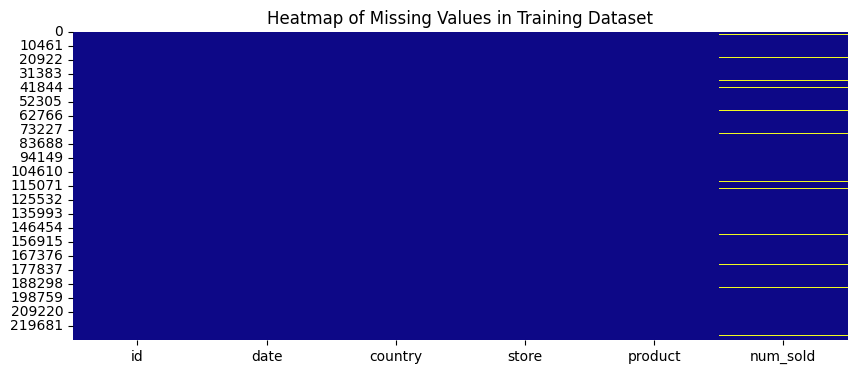

In [ ]:
plt.figure(figsize=(10, 4))
sns.heatmap(train.isnull(), cbar=False, cmap="plasma")
plt.title("Heatmap of Missing Values in Training Dataset")
plt.show()

In [ ]:
train_df_imputed = train.copy()
print(f"Missing values remaining: {train_df_imputed['num_sold'].isna().sum()}")

# Extract the year from the date
train_df_imputed['date'] = pd.to_datetime(train_df_imputed['date'])
train_df_imputed["year"] = train_df_imputed["date"].dt.year

# Loop through each year to perform imputation
for year in train_df_imputed["year"].unique():
    # Target ratio (Norway)
    target_ratio = gdp_per_capita_filtered_ratios_df.loc[
        (gdp_per_capita_filtered_ratios_df["year"] == year) &
        (gdp_per_capita_filtered_ratios_df["country"] == "Norway"), "ratio"
    ].values[0]

    # Impute Time Series 1: Canada, Discount Stickers, Holographic Goose
    current_ratio_can = gdp_per_capita_filtered_ratios_df.loc[
        (gdp_per_capita_filtered_ratios_df["year"] == year) &
        (gdp_per_capita_filtered_ratios_df["country"] == "Canada"), "ratio"
    ].values[0]
    ratio_can = current_ratio_can / target_ratio
    train_df_imputed.loc[
        (train_df_imputed["country"] == "Canada") &
        (train_df_imputed["store"] == "Discount Stickers") &
        (train_df_imputed["product"] == "Holographic Goose") &
        (train_df_imputed["year"] == year),
        "num_sold"
    ] = (
        train_df_imputed.loc[
            (train_df_imputed["country"] == "Norway") &
            (train_df_imputed["store"] == "Discount Stickers") &
            (train_df_imputed["product"] == "Holographic Goose") &
            (train_df_imputed["year"] == year),
            "num_sold"
        ] * ratio_can
    ).values

    # Impute Time Series 2-3: Canada, Premium Sticker Mart / Stickers for Less
    for store in ["Premium Sticker Mart", "Stickers for Less"]:
        current_ts = train_df_imputed.loc[
            (train_df_imputed["country"] == "Canada") &
            (train_df_imputed["store"] == store) &
            (train_df_imputed["product"] == "Holographic Goose") &
            (train_df_imputed["year"] == year)
        ]
        missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
        train_df_imputed.loc[
            (train_df_imputed["country"] == "Canada") &
            (train_df_imputed["store"] == store) &
            (train_df_imputed["product"] == "Holographic Goose") &
            (train_df_imputed["year"] == year) &
            (train_df_imputed["date"].isin(missing_ts_dates)),
            "num_sold"
        ] = (
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Norway") &
                (train_df_imputed["store"] == store) &
                (train_df_imputed["product"] == "Holographic Goose") &
                (train_df_imputed["year"] == year) &
                (train_df_imputed["date"].isin(missing_ts_dates)),
                "num_sold"
            ] * ratio_can
        ).values

    # Impute Time Series 4: Kenya, Discount Stickers, Holographic Goose
    current_ratio_ken = gdp_per_capita_filtered_ratios_df.loc[
        (gdp_per_capita_filtered_ratios_df["year"] == year) &
        (gdp_per_capita_filtered_ratios_df["country"] == "Kenya"), "ratio"
    ].values[0]
    ratio_ken = current_ratio_ken / target_ratio
    train_df_imputed.loc[
        (train_df_imputed["country"] == "Kenya") &
        (train_df_imputed["store"] == "Discount Stickers") &
        (train_df_imputed["product"] == "Holographic Goose") &
        (train_df_imputed["year"] == year),
        "num_sold"
    ] = (
        train_df_imputed.loc[
            (train_df_imputed["country"] == "Norway") &
            (train_df_imputed["store"] == "Discount Stickers") &
            (train_df_imputed["product"] == "Holographic Goose") &
            (train_df_imputed["year"] == year),
            "num_sold"
        ] * ratio_ken
    ).values

    # Impute Time Series 5-6: Kenya, Premium Sticker Mart / Stickers for Less
    for store in ["Premium Sticker Mart", "Stickers for Less"]:
        current_ts = train_df_imputed.loc[
            (train_df_imputed["country"] == "Kenya") &
            (train_df_imputed["store"] == store) &
            (train_df_imputed["product"] == "Holographic Goose") &
            (train_df_imputed["year"] == year)
        ]
        missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
        train_df_imputed.loc[
            (train_df_imputed["country"] == "Kenya") &
            (train_df_imputed["store"] == store) &
            (train_df_imputed["product"] == "Holographic Goose") &
            (train_df_imputed["year"] == year) &
            (train_df_imputed["date"].isin(missing_ts_dates)),
            "num_sold"
        ] = (
            train_df_imputed.loc[
                (train_df_imputed["country"] == "Norway") &
                (train_df_imputed["store"] == store) &
                (train_df_imputed["product"] == "Holographic Goose") &
                (train_df_imputed["year"] == year) &
                (train_df_imputed["date"].isin(missing_ts_dates)),
                "num_sold"
            ] * ratio_ken
        ).values

    # Impute Time Series 7: Kenya, Discount Stickers, Kerneler
    current_ts = train_df_imputed.loc[
        (train_df_imputed["country"] == "Kenya") &
        (train_df_imputed["store"] == "Discount Stickers") &
        (train_df_imputed["product"] == "Kerneler") &
        (train_df_imputed["year"] == year)
    ]
    missing_ts_dates = current_ts.loc[current_ts["num_sold"].isna(), "date"]
    train_df_imputed.loc[
        (train_df_imputed["country"] == "Kenya") &
        (train_df_imputed["store"] == "Discount Stickers") &
        (train_df_imputed["product"] == "Kerneler") &
        (train_df_imputed["year"] == year) &
        (train_df_imputed["date"].isin(missing_ts_dates)),
        "num_sold"
    ] = (
        train_df_imputed.loc[
            (train_df_imputed["country"] == "Norway") &
            (train_df_imputed["store"] == "Discount Stickers") &
            (train_df_imputed["product"] == "Kerneler") &
            (train_df_imputed["year"] == year) &
            (train_df_imputed["date"].isin(missing_ts_dates)),
            "num_sold"
        ] * ratio_ken
    ).values

# Check for remaining missing values
print(f"Missing values remaining after imputation: {train_df_imputed['num_sold'].isna().sum()}")

# Manual imputation for specific IDs
train_df_imputed.loc[train_df_imputed["id"] == 23719, "num_sold"] = 4
train_df_imputed.loc[train_df_imputed["id"] == 207003, "num_sold"] = 195

# Final check for missing values
print(f"Final missing values remaining: {train_df_imputed['num_sold'].isna().sum()}")

Missing values remaining: 8871
Missing values remaining after imputation: 2
Final missing values remaining: 0


# Feature Engineering

In [ ]:
train_df_imputed.head()

,id,date,country,store,product,num_sold,year
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,140.799481,2010
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.000000,2010
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.000000,2010
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.000000,2010
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.000000,2010


In [ ]:
train = train_df_imputed.copy()
train["year"] = train["date"].dt.year
train["month"] = train["date"].dt.month
train["day_of_week"] = train["date"].dt.dayofweek
train["day_of_year"] = train["date"].dt.dayofyear
train["week_of_year"] = train["date"].dt.isocalendar().week
train["is_weekend"] = train["day_of_week"].isin([5, 6]).astype(int)
train["quarter"] = train["date"].dt.quarter

# Lag Features
train["num_sold_lag_1"] = train["num_sold"].shift(1)
train["num_sold_lag_7"] = train["num_sold"].shift(7)
train["num_sold_lag_30"] = train["num_sold"].shift(30)

# Rolling Features
train["num_sold_rolling_7"] = train["num_sold"].rolling(window=7, min_periods=1).mean()
train["num_sold_rolling_30"] = train["num_sold"].rolling(window=30, min_periods=1).mean()
train["num_sold_exp_weighted_7"] = train["num_sold"].ewm(span=7, adjust=False).mean()

train["store_product"] = train["store"] + "_" + train["product"]
train["country_store"] = train["country"] + "_" + train["store"]
train["country_product"] = train["country"] + "_" + train["product"]

# Create mapping
store_mapping = {k: v for v, k in enumerate(train["store"].unique())}
country_mapping = {k: v for v, k in enumerate(train["country"].unique())}
product_mapping = {k: v for v, k in enumerate(train["product"].unique())}

train["store_encoded"] = train["store"].map(store_mapping)
train["country_encoded"] = train["country"].map(country_mapping)
train["productt_encoded"] = train["product"].map(product_mapping)

### **Adding Holiday Feature**
country_holiday_map = {
    "Canada": "CA",
    "Finland": "FI",
    "Italy": "IT",
    "Kenya": "KE",
    "Norway": "NO",
    "Singapore": "SG"
}

# Create holiday dictionaries for each country
holidays_dict = {
    country: holidays.country_holidays(iso_code, years=range(train["year"].min(), train["year"].max() + 1))
    for country, iso_code in country_holiday_map.items()
}

train["is_holiday"] = train.apply(lambda row: int(row["date"] in holidays_dict[row["country"]]), axis=1)

### **Adding Sin/Cos Features for Cyclical Encoding**
train["month_sin"] = np.sin(2 * np.pi * train["month"] / 12.0)
train["month_cos"] = np.cos(2 * np.pi * train["month"] / 12.0)
train["day_of_week_sin"] = np.sin(2 * np.pi * train["day_of_week"] / 7.0)
train["day_of_week_cos"] = np.cos(2 * np.pi * train["day_of_week"] / 7.0)
train["day_of_year_sin"] = np.sin(2 * np.pi * train["day_of_year"] / 365.0)
train["day_of_year_cos"] = np.cos(2 * np.pi * train["day_of_year"] / 365.0)
train["week_of_year_sin"] = np.sin(2 * np.pi * train["week_of_year"] / 52.0)
train["week_of_year_cos"] = np.cos(2 * np.pi * train["week_of_year"] / 52.0)

train["half_year_sin"] = np.sin(2 * np.pi * train["month"] / 6)
train["half_year_cos"] = np.cos(2 * np.pi * train["month"] / 6)

# 2-year cycle
train["two_year_sin"] = np.sin(2 * np.pi * train["year"] / 2)
train["two_year_cos"] = np.cos(2 * np.pi * train["year"] / 2)

# 3-year cycle
train["three_year_sin"] = np.sin(2 * np.pi * train["year"] / 3)
train["three_year_cos"] = np.cos(2 * np.pi * train["year"] / 3)

# 4-year cycle
train["four_year_sin"] = np.sin(2 * np.pi * train["year"] / 4)
train["four_year_cos"] = np.cos(2 * np.pi * train["year"] / 4)


In [ ]:
train.head()

,id,date,country,store,product,num_sold,year,month,day_of_week,day_of_year,...,week_of_year_sin,week_of_year_cos,half_year_sin,half_year_cos,two_year_sin,two_year_cos,three_year_sin,three_year_cos,four_year_sin,four_year_cos
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,140.799481,2010,1,4,1,...,0.120537,0.992709,0.866025,0.5,-6.851832e-14,1.0,-3.488438e-13,1.0,3.425916e-14,-1.0
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.000000,2010,1,4,1,...,0.120537,0.992709,0.866025,0.5,-6.851832e-14,1.0,-3.488438e-13,1.0,3.425916e-14,-1.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.000000,2010,1,4,1,...,0.120537,0.992709,0.866025,0.5,-6.851832e-14,1.0,-3.488438e-13,1.0,3.425916e-14,-1.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.000000,2010,1,4,1,...,0.120537,0.992709,0.866025,0.5,-6.851832e-14,1.0,-3.488438e-13,1.0,3.425916e-14,-1.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.000000,2010,1,4,1,...,0.120537,0.992709,0.866025,0.5,-6.851832e-14,1.0,-3.488438e-13,1.0,3.425916e-14,-1.0


In [ ]:
train.columns

Index(['id', 'date', 'country', 'store', 'product', 'num_sold', 'year',
       'month', 'day_of_week', 'day_of_year', 'week_of_year', 'is_weekend',
       'quarter', 'num_sold_lag_1', 'num_sold_lag_7', 'num_sold_lag_30',
       'num_sold_rolling_7', 'num_sold_rolling_30', 'num_sold_exp_weighted_7',
       'store_product', 'country_store', 'country_product', 'store_encoded',
       'country_encoded', 'productt_encoded', 'is_holiday', 'month_sin',
       'month_cos', 'day_of_week_sin', 'day_of_week_cos', 'day_of_year_sin',
       'day_of_year_cos', 'week_of_year_sin', 'week_of_year_cos',
       'half_year_sin', 'half_year_cos', 'two_year_sin', 'two_year_cos',
       'three_year_sin', 'three_year_cos', 'four_year_sin', 'four_year_cos'],
      dtype='object')

In [ ]:
features = ["year",
            "month",
            "day_of_week",
            "day_of_year",
            "week_of_year",
            "is_weekend",
            "quarter",
            "num_sold_lag_1",
            "num_sold_lag_7",
            "num_sold_lag_30",
            "num_sold_rolling_7",
            "num_sold_rolling_30",
            "num_sold_exp_weighted_7",
            #"fourier_real",
            #"fourier_imag"
            'store_encoded',
            'country_encoded',
            'productt_encoded',
            'is_holiday',
            'month_sin',
            'month_cos',
            'day_of_week_sin',
            'day_of_week_cos',
            'day_of_year_sin',
            'day_of_year_cos',
            'week_of_year_sin',
            'week_of_year_cos',
            'half_year_sin',
            'half_year_cos',
            'two_year_sin',
            'two_year_cos',
            'three_year_sin',
            'three_year_cos',
            'four_year_sin',
            'four_year_cos'
            ]

In [ ]:
X_train, y_train = train[features], train["num_sold"]

In [ ]:
lgb_model = LGBMRegressor(
    boosting_type="gbdt",
    objective="poisson",
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=12,
    random_state=0
)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2570
[LightGBM] [Info] Number of data points in the train set: 230130, number of used features: 33
[LightGBM] [Info] Start training from score 6.587612


LGBMRegressor(max_depth=12, n_estimators=1000, objective='poisson',
              random_state=0)

In [ ]:
#def objective(trial):
#    # Suggest hyperparameters
#    params = {
#        "boosting_type": "gbdt",
#        "objective": "poisson",
#        "n_estimators": trial.suggest_int("n_estimators", 800, 1200),
#        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15, log=True),
#        "max_depth": trial.suggest_int("max_depth", 10, 16),
#        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
#        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
#        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
#        "random_state": 0,
#    }
#    model = LGBMRegressor(**params)
#    model.fit(X_train, y_train)  # No validation set
#
#    # Predict on training data itself
#    preds = model.predict(X_train)
#    preds = np.maximum(preds, 0)  # Clip negative values
#    mape = mean_absolute_percentage_error(y_train, preds)
#
#    return mape

In [ ]:
y_pred = lgb_model.predict(X_train)

In [ ]:
#study = optuna.create_study(direction="minimize")
#study.optimize(objective, n_trials=20)

#print("Best parameters:", study.best_params)
#print("Best MAPE:", study.best_value)

In [ ]:
#print("Best parameters:", study.best_params)
#print("Best MAPE:", study.best_value)

In [ ]:
#best_params = study.best_params
#final_model = LGBMRegressor(**best_params)
#final_model.fit(X_train, y_train)

#y_pred = final_model.predict(X_train)

##final_mape = mean_absolute_percentage_error(y_train, y_pred)
#print(f"Final Model MAPE: {final_mape:.6f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2571
[LightGBM] [Info] Number of data points in the train set: 230130, number of used features: 33
[LightGBM] [Info] Start training from score 726.044644
Final Model MAPE: 0.090188


In [ ]:
results_df = pd.DataFrame({
    'actual_sales': train['num_sold'],
    'predicted_sales': y_pred
})

In [ ]:
mape = mean_absolute_percentage_error(results_df.actual_sales, results_df.predicted_sales)
mape

0.042892112031676054

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train = train_df_imputed

In [ ]:
final_model

LGBMRegressor(colsample_bytree=0.7546776478981373,
              learning_rate=0.14183991622541411, max_depth=13,
              n_estimators=1151, reg_alpha=0.6279200172202164,
              reg_lambda=0.9661090589793975)

In [ ]:
def iterative_forecast_with_history(model, train_df, test_df):
    test_df = test_df.copy()
    train_df["date"] = pd.to_datetime(train_df["date"])
    test_df["date"] = pd.to_datetime(test_df["date"])

    last_30_days = train_df.tail(30)
    extended_test_df = pd.concat([last_30_days, test_df], ignore_index=True)
    print(extended_test_df)

    predictions = []

    # Now loop through the extended test set (the last 30 rows in extended_test_df are the actual test data)
    for i in range(len(last_30_days), len(extended_test_df)):
        if i % 500 == 0:
            print(f"Processing row {i}")
        row = extended_test_df.iloc[i].copy()


        row["year"] = row["date"].year
        row["month"] = row["date"].month
        row["day_of_week"] = row["date"].dayofweek
        row["day_of_year"] = row["date"].dayofyear
        row["week_of_year"] = row["date"].isocalendar().week
        row["is_weekend"] = 1 if row["day_of_week"] in [5, 6] else 0
        row["quarter"] = row["date"].quarter

        if len(predictions) > 0:
            row["num_sold_lag_1"] = predictions[-1]
        else:
            row["num_sold_lag_1"] = np.nan
        #print('!!', i, extended_test_df["num_sold"].iloc[i - 30])
        row["num_sold_lag_7"] = extended_test_df["num_sold"].iloc[i - 7]
        row["num_sold_lag_30"] = extended_test_df["num_sold"].iloc[i - 30]

        row["num_sold_rolling_7"] = extended_test_df["num_sold"].iloc[:i].tail(7).mean()
        row["num_sold_rolling_30"] = extended_test_df["num_sold"].iloc[:i].tail(30).mean()

        # For exponential weighted sum (you may need to use previous values to calculate the weighted sum)
        row["num_sold_exp_weighted_7"] = extended_test_df["num_sold"].iloc[:i].ewm(span=7).mean().iloc[-1]

        # Fourier features based on previous predictions
        #row["fourier_real"] = np.real(np.fft.fft(predictions)[-1]) if len(predictions) > 0 else 0
        #row["fourier_imag"] = np.imag(np.fft.fft(predictions)[-1]) if len(predictions) > 0 else 0

        row["store_encoded"] = store_mapping.get(row["store"], -1)
        row["country_encoded"] = country_mapping.get(row["country"], -1)
        row["productt_encoded"] = product_mapping.get(row["product"], -1)

        # Holiday Feature
        row["is_holiday"] = int(row["date"] in holidays_dict.get(row["country"], []))

        # Cyclical Features (Sin/Cos Transformations)
        row["month_sin"] = np.sin(2 * np.pi * row["month"] / 12.0)
        row["month_cos"] = np.cos(2 * np.pi * row["month"] / 12.0)
        row["day_of_week_sin"] = np.sin(2 * np.pi * row["day_of_week"] / 7.0)
        row["day_of_week_cos"] = np.cos(2 * np.pi * row["day_of_week"] / 7.0)
        row["day_of_year_sin"] = np.sin(2 * np.pi * row["day_of_year"] / 365.0)
        row["day_of_year_cos"] = np.cos(2 * np.pi * row["day_of_year"] / 365.0)
        row["week_of_year_sin"] = np.sin(2 * np.pi * row["week_of_year"] / 52.0)
        row["week_of_year_cos"] = np.cos(2 * np.pi * row["week_of_year"] / 52.0)

        # exatra
        row["half_year_sin"] = np.sin(2 * np.pi * row["month"] / 6.0)
        row["half_year_cos"] = np.cos(2 * np.pi * row["month"] / 6.0)

        row["two_year_sin"] = np.sin(2 * np.pi * row["year"] / 2.0)
        row["two_year_cos"] = np.cos(2 * np.pi * row["year"] / 2.0)

        row["three_year_sin"] = np.sin(2 * np.pi * row["year"] / 3.0)
        row["three_year_cos"] = np.cos(2 * np.pi * row["year"] / 3.0)

        row["four_year_sin"] = np.sin(2 * np.pi * row["year"] / 4.0)
        row["four_year_cos"] = np.cos(2 * np.pi * row["year"] / 4.0)

        # Prepare features for the model
        row_df = pd.DataFrame([row[features]])
        #print('row_df: ', row_df)

        pred = model.predict(row_df)[0]
        predictions.append(pred)
        extended_test_df.at[i, 'num_sold'] = pred
        #print(int(row["date"] in holidays_dict.get(row["country"], [])))
    return predictions

# ------------------ Using the Function ------------------
predictions = iterative_forecast_with_history(lgb_model, train, test)

           id       date    country                 store             product  \
0      230100 2016-12-31     Norway     Discount Stickers   Holographic Goose   
1      230101 2016-12-31     Norway     Discount Stickers              Kaggle   
2      230102 2016-12-31     Norway     Discount Stickers        Kaggle Tiers   
3      230103 2016-12-31     Norway     Discount Stickers            Kerneler   
4      230104 2016-12-31     Norway     Discount Stickers  Kerneler Dark Mode   
...       ...        ...        ...                   ...                 ...   
98575  328675 2019-12-31  Singapore  Premium Sticker Mart   Holographic Goose   
98576  328676 2019-12-31  Singapore  Premium Sticker Mart              Kaggle   
98577  328677 2019-12-31  Singapore  Premium Sticker Mart        Kaggle Tiers   
98578  328678 2019-12-31  Singapore  Premium Sticker Mart            Kerneler   
98579  328679 2019-12-31  Singapore  Premium Sticker Mart  Kerneler Dark Mode   

       num_sold    year  
0

In [ ]:
predictions = np.clip(predictions, 5, 7000)
submission = pd.DataFrame({"id": test["id"], "num_sold":predictions})

In [ ]:
submission.set_index("id", inplace=True)
submission["num_sold"] = submission["num_sold"].round()
submission.to_csv("submission_09.csv")

In [ ]:
np.mean(predictions)

253.9790931242678